In [43]:
import pandas as pd
from tqdm import tqdm
import math
import json
import heapq  
from utils.contribution import contribution_chart
import sys
import os
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# 保证绝对路径可以被检测到
sys.path.append("\\".join(sys.path[0].split("\\")[:-1]))

In [44]:
id_test = 0
id_temporal_len = 100
test_path = 'Set6_1'
dataset_type = 'mff'
folder_path = './fig/'+dataset_type+'/'+test_path+'/'
if not os.path.isdir(folder_path):
    os.makedirs(folder_path)

3


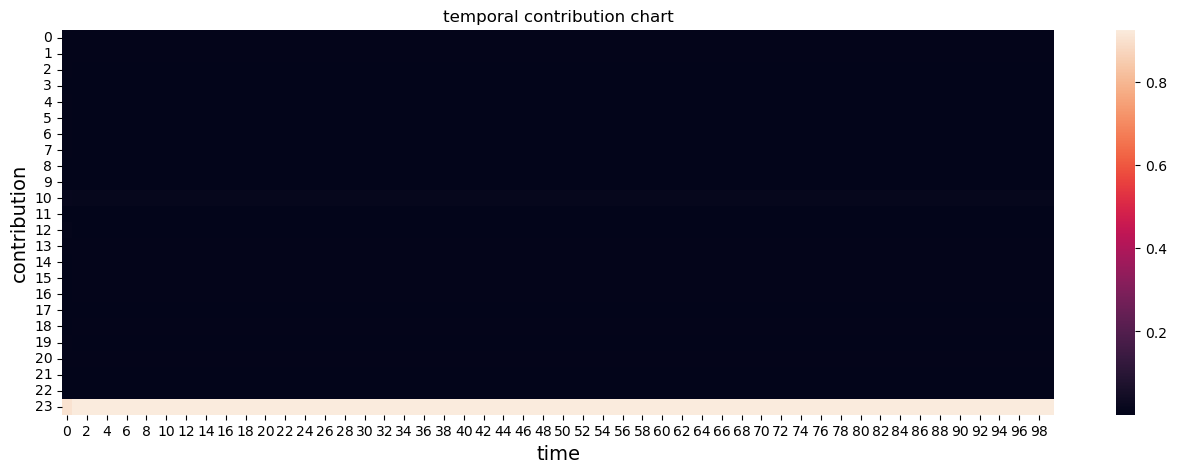

In [45]:
def preprocess_cont_chart(id_test,id_temporal_len,dataset_type,test_path):
    t2_cont_list,spe_cont_list,rbc_cont_list,num_pc = contribution_chart(test_path,num_pc=0,PCA_components_rate=0.8,temporal=True,id_test=id_test,id_temporal_len=id_temporal_len,dataset_type=dataset_type)
    print(num_pc)
    cont_list = rbc_cont_list
    cont_list = cont_list[0:id_temporal_len]
    cont_list=cont_list/np.sum(cont_list,axis=1).reshape(-1,1)
    plt.figure(figsize=(16,5))
    ax = sns.heatmap(cont_list.transpose(),cbar=True) # vmin和vmax是自定义显示颜色的范围
    plt.title("temporal contribution chart") # 设置标题
    plt.xlabel("time", fontsize=14) # 设置x标题
    plt.ylabel("contribution", fontsize=14) # 设置y轴标题
    # plt.savefig(fig_name,bbox_inches='tight',dpi=300)
    plt.show()
    return cont_list
cont_list = preprocess_cont_chart(id_test,id_temporal_len,dataset_type,test_path)

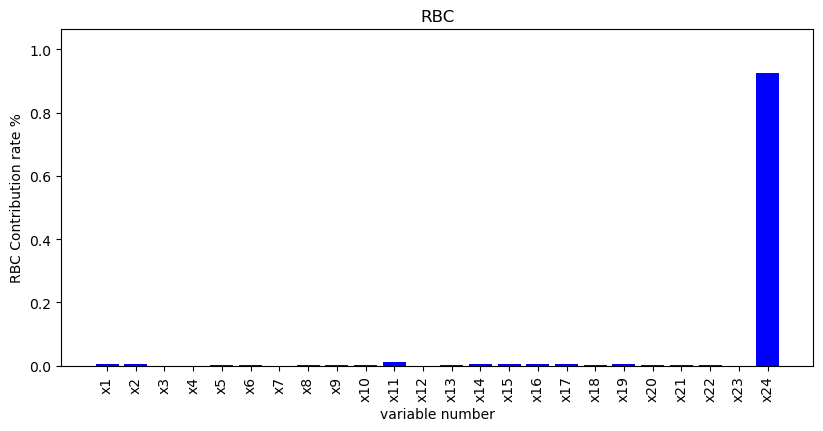

In [46]:
sequence_cont = [np.sum(cont) for cont in cont_list.transpose()]/np.sum(cont_list)
variable_names = ['x'+str(i) for i in range(1,len(sequence_cont)+1)]
plt.figure(figsize=(16,12))
plt.subplot(3,2,1)
plt.bar(variable_names, sequence_cont, color='blue')
plt.xticks(rotation=90)
plt.xlabel('variable number')
plt.ylabel('RBC Contribution rate %')
plt.title('RBC')
plt.ylim(0, max(sequence_cont) * 1.15)
plt.tight_layout()

In [47]:
best_x =[10,  50, 100,   1,   1,  3]
# best_x = [  1.,   3., 200.,   5.,   6.,  13.]
param_State_loss = best_x[0]/10
param_Output_loss = best_x[1]/10
param_Contain_loss = best_x[2]/10
param_Contained_loss = best_x[2]/10
param_State_disp = 1
param_Output_disp = 1
param_Contain_disp = 1
param_Contained_disp = 1
param_State_time = best_x[3]
param_Output_time = best_x[4]
param_Contain_time = best_x[5]
param_Contained_time = best_x[5]
relation_loss_dict = {'State_of':param_State_loss,'State':param_State_loss,'Output':param_Output_loss,'Contain':param_Contain_loss,'Contained_by':param_Contained_loss}
distance_punishment = {'State_of':param_State_disp,'State':param_State_disp,'Output':param_Output_disp,'Contain':param_Contain_disp,'Contained_by':param_Contained_disp}
relation_time_delay = {'State_of':param_State_time,'State':param_State_time,'Output':param_Output_time,'Contain':param_Contain_time,'Contained_by':param_Contained_time}

if test_path!='Set6_1' and test_path!='Set6_2':
    with open('data_mff/simple_graph.json', 'r') as f:
        kg_graph = json.load(f)
    # with open('data_mff/graph.json', 'r') as f:
    #     kg_graph = json.load(f)
else:
    with open('data_mff/graph.json', 'r') as f:
        kg_graph = json.load(f)

node_df = pd.read_csv('data_mff/MFF-KG-Node.csv')

variable_names,stream_names,device_names,substance_names = [],[],[],[]
for i,row in node_df.iterrows():
    if row['Type']=='Variable':
        if test_path!='Set6_1' and test_path!='Set6_2':
            if row['Node']!='x24':
                variable_names.append(row['Node'])
            # variable_names.append(row['Node'])
        else:   
            variable_names.append(row['Node'])
    if row['Type']=='Stream':
        stream_names.append(row['Node'])
    if row['Type']=='Device':
        device_names.append(row['Node'])
    if row['Type']=='Substance':
        substance_names.append(row['Node'])
key_order = variable_names+stream_names+device_names+substance_names
sorted_items = sorted(kg_graph.items(), key=lambda item: key_order.index(item[0]))
kg_graph = dict(sorted_items)
#节点最大传播次数
max_propagate_times = 10
mode = "simulate"
sequence_cont = [np.sum(cont) for cont in cont_list.transpose()]/np.sum(cont_list)


def func_sigmoid(x,p):
    sigmoid_x = 1 / (1 + np.exp(-p*x))
    y = (1-sigmoid_x)*2
    return y

def Depre_path_loss(path_loss):
    #根据路径长度计算折旧
    param_path_depre = 0.1
    # return math.exp(-param_path_depre*path_loss)
    return func_sigmoid(path_loss,param_path_depre)

def Depre_child_node(count_child):
    #子节点数目过多带来的损耗
    min_child_node = 1
    if count_child<min_child_node:
        return 1
    param_child_node = 0.01
    # return math.exp(-param_child_node*count_child)
    return func_sigmoid(count_child-min_child_node,param_child_node)

def Depre_propagated(propagate_times,dis_punish):
    #被传播带来的折旧
    return 1/(propagate_times*dis_punish)
    
class PriorityQueue(object):
    def __init__(self):
        self._queue = []
        self._index = 0

    def push(self, item):
        """
        队列由 (priority, index, item) 形式组成
        priority 增加 "-" 号是因为 heappush 默认是最小堆
        index 是为了当两个对象的优先级一致时，按照插入顺序排列
        """
        priority = item.time
        heapq.heappush(self._queue, (priority, self._index, item))
        self._index += 1

    def pop(self):
        """
        弹出优先级最高的对象
        """
        return heapq.heappop(self._queue)[-1]

    def qsize(self):
        return len(self._queue)

    def empty(self):
        return True if not self._queue else False

class TimeNode(object):
    def __init__(self, node, time):
        self.node = node
        self.time = time

    def __repr__(self):
        return "{0} - {1}".format(self.node, self.time)


def bfs_simulate(startnode,sequence_cont,relation_loss_dict,distance_punishment,relation_time_delay):
    pq = PriorityQueue()

    map_node_visit = {}#节点被访问次数，相当于节点被别的节点传播损耗的次数
    map_node_propagate = {}#节点作为visit节点的次数，相当于节点向别的节点传播损耗的次数
    map_node_simu_score = {}#节点的模拟得分
    map_node_propagated_score = {} #节点被其他节点传播的量，可以据此回溯到其主要影响节点
    for node in kg_graph.keys():
        map_node_visit[node] = 0
        map_node_propagate[node] = 0
        map_node_simu_score[node] = 0
        map_node_propagated_score[node] = {}
    timer = 0#计时器
    pq.push(TimeNode(startnode,timer))
    map_node_visit[startnode] = 1
    map_node_simu_score[startnode] = 1
    while pq.qsize():#保障还有元素
        for _ in range(pq.qsize()):#同一层级的node遍历
            #子节点得分计算
            visit_timenode = pq.pop()
            visit_node = visit_timenode.node
            map_node_propagate[visit_node]+=1
            for node in kg_graph[visit_node].keys():
                count_child = len(kg_graph[visit_node])
                #原始的广度优先搜索，每个节点只能被访问一次
                if mode == "bfs": 
                    if not map_node_visit[node]:
                        map_node_visit[node]+=1
                        relation = kg_graph[visit_node][node]
                        map_node_simu_score[node] += map_node_simu_score[visit_node]*Depre_path_loss(relation_loss_dict[relation])*1/count_child
                        pq.push(TimeNode(node,1))#不考虑时间问题
                #基于BFS的流程模拟方法，每个节点向别的节点传播损耗的次数有限制，当只能传播一次时，相当于访问了所有的边
                elif mode == "simulate":
                    if map_node_propagate[visit_node]<=max_propagate_times:
                        #visit_node->node 误差传播过程
                        relation = kg_graph[visit_node][node]
                        #visit节点的损耗需要根据其被传播的损耗进行折旧，然后再乘上路径损耗
                        propagate_error = map_node_simu_score[visit_node]*Depre_propagated(map_node_visit[visit_node],distance_punishment[relation])*Depre_path_loss(relation_loss_dict[relation])*Depre_child_node(count_child)
                        pq.push(TimeNode(node,timer+relation_time_delay[relation]))
                        map_node_simu_score[node] +=propagate_error
                        if visit_node not in map_node_propagated_score[node].keys():
                            map_node_propagated_score[node][visit_node]=0
                        map_node_propagated_score[node][visit_node]+=propagate_error
                        map_node_visit[node]+=1
                timer+=1
    #计算相似度
    start_cont = 1
    for i in range(0,len(variable_names)):
        if variable_names[i]==startnode:
            start_cont = sequence_cont[i]
    sequence_simu = [v*start_cont/map_node_simu_score[startnode] for v in map_node_simu_score.values()]
    sequence_cont = np.array(sequence_cont)
    sequence_simu = np.array(sequence_simu)[0:len(variable_names)]
    sim_score = np.dot(sequence_cont, sequence_simu) / (np.linalg.norm(sequence_cont) * np.linalg.norm(sequence_simu))
    return sim_score,sequence_simu,map_node_propagated_score

dict_simu_score = {}
dict_sequence_simu = {}
for startnode in key_order:
    dict_simu_score[startnode],dict_sequence_simu[startnode],map_node_propagated_score = bfs_simulate(startnode,sequence_cont,relation_loss_dict,distance_punishment,relation_time_delay)
sorted_items = sorted(dict_simu_score.items(), key=lambda item: item[1],reverse=True)
dict_simu_score = dict(sorted_items)
dict_simu_score

{'x24': 0.7310930805179678,
 'Stream 4 bottom': 0.642017149090878,
 'VC201': 0.3998313599644455,
 'Stream 2': 0.3938879033406333,
 'Stream 3': 0.390421635669542,
 'x1': 0.37280530624954283,
 'x8': 0.37276868566049615,
 'Stream 1': 0.3620316765555934,
 'VC302': 0.35508639765929934,
 'x15': 0.34911648801794376,
 'x18': 0.3489944066756299,
 'x9': 0.34893517362287474,
 'PO2': 0.33848765421342597,
 'x21': 0.33663910961427784,
 'VC101': 0.3272111218406294,
 'R300': 0.31864506540618054,
 'x22': 0.3144212131065851,
 'T200': 0.27719701716424056,
 'PO1': 0.27082613497185637,
 'x23': 0.25578674509172267,
 'air': 0.20276772899280845,
 'T100': 0.18870181593835308,
 'CW500': 0.17341918778592694,
 'oil': 0.16474313494833717,
 'Stream 8': 0.16251162661747373,
 'Stream 9': 0.1608935357848377,
 'Stream 4': 0.1567751570450167,
 'CO500': 0.15249268153145376,
 'water': 0.15161405695434838,
 'VC401': 0.13519412783886803,
 'VC402': 0.1236238861078821,
 'Stream 6': 0.1230145184477106,
 'Stream 11': 0.10883430

In [48]:
sequence_cont
indices_sorted = np.argsort(sequence_cont, axis=0)[-6:]
sorted_var = [variable_names[i] for i in sorted(indices_sorted)]
sorted_var

['x11', 'x14', 'x15', 'x16', 'x17', 'x24']

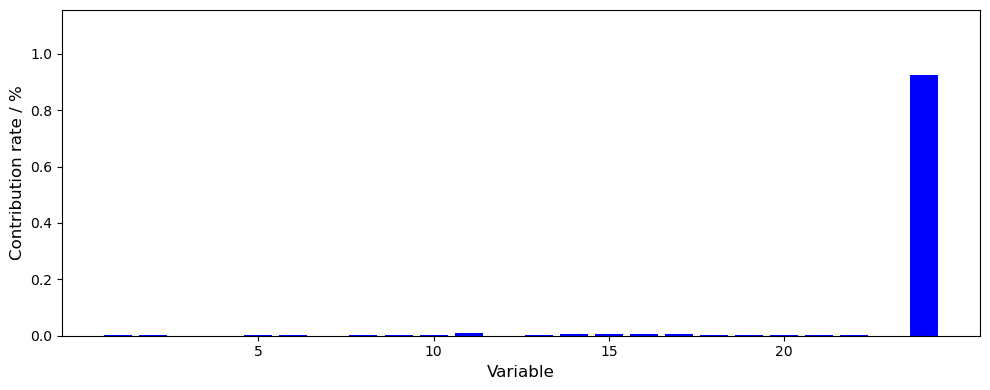

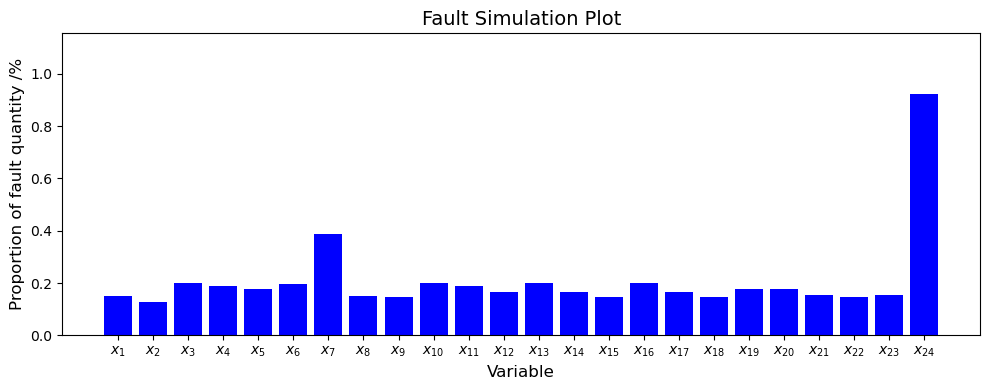

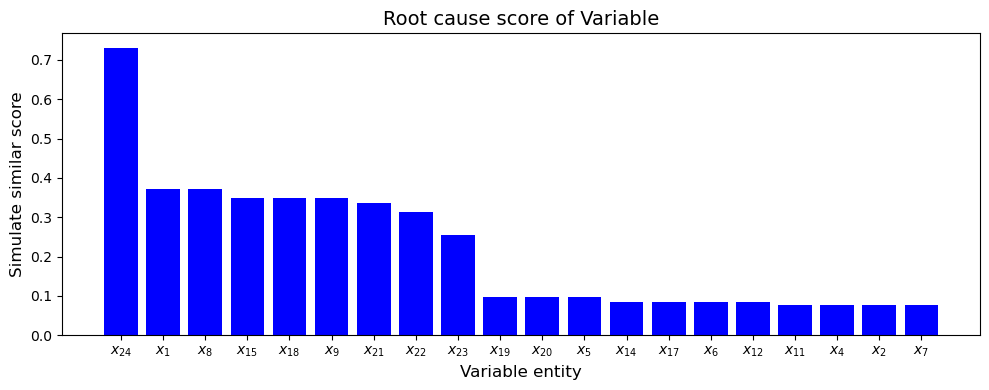

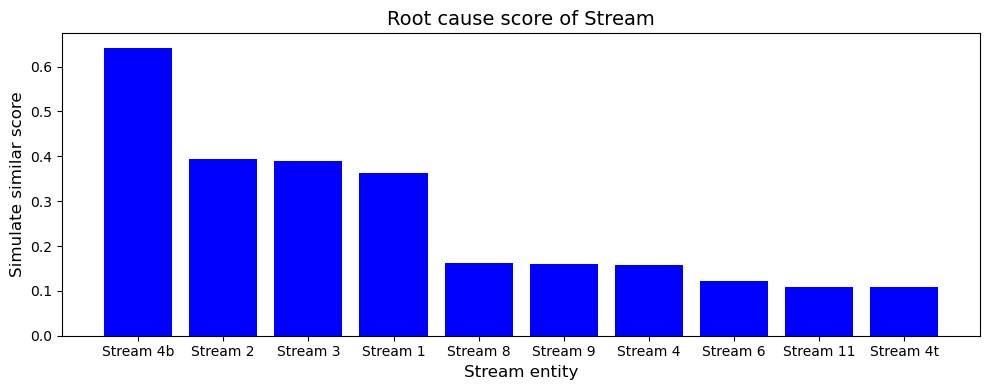

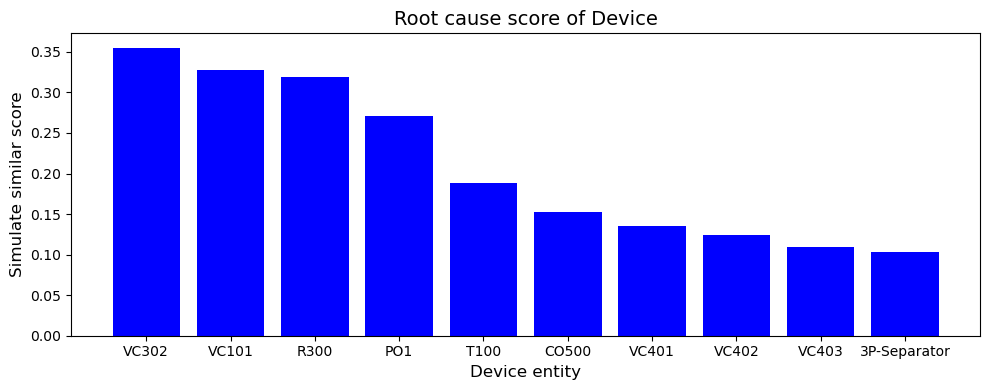

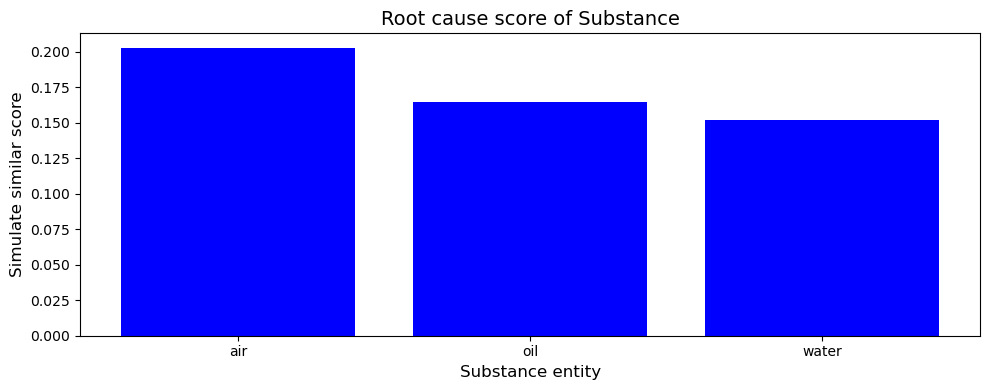

In [51]:
rank_node = [startnode for startnode in dict_simu_score.keys()]
for startnode in rank_node:
    if startnode in variable_names:
        best_start_node = startnode
        break

xlablefront = 12
ylablefront = 12
titlefront = 14
figxsize = 10
figysize = 4

def markdown_x(v):
    return '$'+v[:1]+'_{'+v[1:]+'}$'

def markdown_Stream(v):
    if 'top' in v:
        return v[:-4]+'t'
    if 'bottom' in v:
        return v[:-7]+'b'
    return v

def markdown_Device(v):
    if '2 Phase Separator' == v:
        return '2P-Separator'
    if '3 Phase Separator' == v:
        return '3P-Separator'
    return v

# plt.figure(figsize=(20,12))
plt.figure(figsize=(figxsize,figysize))
# plt.subplot(3,2,1)
# plt.bar([markdown_x(v) for v in variable_names], sequence_cont, color='blue')
plt.bar([str(x) for x in range(1,len(sequence_cont)+1)], sequence_cont, color='blue')
plt.xticks([str(x) for x in range(5,len(sequence_cont)+1,5)])
# plt.xticks(rotation=90)
plt.xlabel('Variable', fontsize=xlablefront)
plt.ylabel('Contribution rate / %', fontsize=ylablefront)
# plt.title('RBC Contribution plot', fontsize=titlefront)
plt.ylim(0, max(sequence_cont) * 1.25)
plt.tight_layout()
plt.savefig(folder_path+'contribution.png')

# plt.subplot(3,2,2)
plt.figure(figsize=(figxsize,figysize))
plt.bar([markdown_x(v) for v in variable_names], dict_sequence_simu[best_start_node], color='blue')
# plt.xticks(rotation=90)
plt.xlabel('Variable', fontsize=xlablefront)
plt.ylabel('Proportion of fault quantity /%', fontsize=ylablefront)
plt.title('Fault Simulation Plot', fontsize=titlefront)
plt.ylim(0, max(sequence_cont) * 1.25)
plt.tight_layout()
plt.savefig(folder_path+'Simulation.png')

rank_var = [v for v in rank_node if v in variable_names][0:20]
# plt.subplot(3,2,3)
plt.figure(figsize=(figxsize,figysize))
plt.bar([markdown_x(v) for v in rank_var], [dict_simu_score[v] for v in rank_var], color='blue')
# plt.xticks(rotation=90)
plt.xlabel('Variable entity', fontsize=xlablefront)
plt.ylabel('Simulate similar score', fontsize=ylablefront)
plt.title('Root cause score of Variable', fontsize=titlefront)
plt.tight_layout()
plt.savefig(folder_path+'Variable_score.png')

rank_s = [v for v in rank_node if v in stream_names][0:10]
# plt.subplot(3,2,4)
plt.figure(figsize=(figxsize,figysize))
plt.bar([markdown_Stream(v) for v in rank_s], [dict_simu_score[v] for v in rank_s], color='blue')
# plt.xticks(rotation=90)
plt.xlabel('Stream entity', fontsize=xlablefront)
plt.ylabel('Simulate similar score', fontsize=ylablefront)
plt.title('Root cause score of Stream', fontsize=titlefront)
# plt.tick_params(labelsize=8)
plt.tight_layout()
plt.savefig(folder_path+'Stream_score.png')

Excluded_device = ['CW500','T200','FT204','VC201','PO2','Stream 11']

rank_d = [v for v in rank_node if v in device_names and v not in Excluded_device][0:10]

# plt.subplot(3,2,4)
plt.figure(figsize=(figxsize,figysize))
plt.bar([markdown_Device(v) for v in rank_d], [dict_simu_score[v] for v in rank_d], color='blue')
# plt.xticks(rotation=90)
plt.xlabel('Device entity', fontsize=xlablefront)
plt.ylabel('Simulate similar score', fontsize=ylablefront)
plt.title('Root cause score of Device', fontsize=titlefront)
# plt.tick_params(labelsize=8)
plt.tight_layout()
plt.savefig(folder_path+'Device_score.png')

# plt.subplot(3,2,5)
plt.figure(figsize=(figxsize,figysize))
plt.bar([v for v in rank_node if v in substance_names], [dict_simu_score[v] for v in rank_node if v in substance_names], color='blue')
# plt.xticks(rotation=90)
plt.xlabel('Substance entity', fontsize=xlablefront)
plt.ylabel('Simulate similar score', fontsize=ylablefront)
plt.title('Root cause score of Substance', fontsize=titlefront)
plt.tight_layout()
plt.savefig(folder_path+'Substance_score.png')

plt.show()